In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm,tnrange
from SD import stochastic_descent

import os
import pandas as pd

In [2]:
def correlation(matrix,h):
    '''
    Given a matrix this function computes the correlation quantity Q(T) as in the paper.
    Matrix must have dimension (n_protocols,lenght_of_protocol)    
    '''
    n_row = matrix.shape[0]
    n_col = matrix.shape[1] 
    
    mean_hx = np.array([matrix[:,i].mean() for i in range(n_col)]) #mean over all protocols at fixed time
    avg_over_h = np.array([np.array([ (matrix[i,j]-mean_hx[j])**2 for i in range(n_row)]).sum()/n_row for j in range(n_col)])
    avg_over_Nt = (1/((h*h)*n_col))*(avg_over_h.sum())
    return  avg_over_Nt

In [3]:
#Starting qstates and their normalization
qstart = np.array([-1/2 - (np.sqrt(5))/2 ,1], dtype=complex)
qtarget = np.array([+1/2 + (np.sqrt(5))/2 ,1], dtype=complex)
qstart=qstart/np.sqrt(np.vdot(qstart,qstart))
qtarget=qtarget/np.sqrt(np.vdot(qtarget,qtarget))
print("qstart",qstart)

qstart [-0.85065081+0.j  0.52573111+0.j]


In [4]:
#SD parameters
L = 1
h = 4
h_list = [-h,h]
nsteps = 100
exp_decay = False
metropolis = False

print("-------------PARAMETERS for SD---------------")
print("Number of qubits (L):", L)
print("Magnetic fields(h):", h)
print("Timesteps (n_steps):", nsteps)
print("\n")
print("\n")

#parameters for Fig. pag 2 ---- Calculation of fidelity and Q(T)
#step_in_time_grid = 0.1
times_first_part=np.arange(0,1,0.05)
times_second_part=np.arange(1,4.1,0.1)
times=np.concatenate([times_first_part,times_second_part])
#times = np.arange(0,4,0.1)#+step_in_time_grid,step=step_in_time_grid)
iter_for_each_time = 35

fidelity_for_txt = []
print("--------------PARAMETERS for Plotting-------------")
print("Timegrid:", times)
print("Repetition at each timestep:", iter_for_each_time)
print("\n")

params_dict = {"L":L, "h":h, "timesteps":nsteps, "exp_decay":exp_decay, "metropolis":metropolis, "times":times, "iter_for_each_time": iter_for_each_time}
params_df = pd.DataFrame.from_dict(params_dict, orient="index")

-------------PARAMETERS for SD---------------
Number of qubits (L): 1
Magnetic fields(h): 4
Timesteps (n_steps): 100




--------------PARAMETERS for Plotting-------------
Timegrid: [0.   0.05 0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5  0.55 0.6  0.65
 0.7  0.75 0.8  0.85 0.9  0.95 1.   1.1  1.2  1.3  1.4  1.5  1.6  1.7
 1.8  1.9  2.   2.1  2.2  2.3  2.4  2.5  2.6  2.7  2.8  2.9  3.   3.1
 3.2  3.3  3.4  3.5  3.6  3.7  3.8  3.9  4.  ]
Repetition at each timestep: 35




In [5]:
#UNCOMMENT TO RUN
print("WARNING! Attenzione a non sovrascrivere")

#save run parameters and date in custom named folder
#os.chdir("C:\Users\GUIDA\Desktop\CODE_MONTANGERO\SD_WITH_REPLACEMENT")
custom_name_dir = "final_data_fixed_nsteps"
os.system("mkdir "+custom_name_dir)
os.system("mkdir "+custom_name_dir+"/protocols")
params_df.to_csv(custom_name_dir+"/parameters.csv")

intermediete_result = True

for T in times:
    temp_fid = []
    best_prot = []
    print("Running time:", T)
    for _ in tnrange(iter_for_each_time):

        best_protocol, fidelity = stochastic_descent(qstart, qtarget, L, T, nsteps, 
                        field_list = h_list, verbose = True, check_norm = True)

        temp_fid.append(fidelity[-1]) #at fixed T we will have "iter_for_each_time" evaluations of fidelity
        best_prot.append(best_protocol) #all iter_for_each_time best protocols are stored in this variable 
                                        #and saved when new rounf over T starts
    fidelity_for_txt.append(temp_fid) #fidelity evaluations are stored in the same "fidelity_fot_txt"
                                      #variable that will have dimension len(times)*iter_for_each_time
    best_prot = np.array([best_prot])
    with open(custom_name_dir +'/protocols/testT'+str(round(T, 2))+'.npy', 'wb') as f:
        np.save(f,best_prot)
    f.close()
    
    if intermediete_result and T !=0: #if T = 0 q cannot be computed
        data = np.load(custom_name_dir +'/protocols/testT'+str(round(T, 3))+'.npy')[0,:,:] #first dimension is redundant 
        print("Mean fidelity:", np.array(temp_fid).mean())
        print("Q value is:", correlation(data, h))
        print("\n")
        
#fidelity values are saved at the end
np.savetxt(custom_name_dir + '/fidelity_SD.txt', fidelity_for_txt, delimiter = ',',header="Matrix with as entries the values of fidelity dimension times x iterations")


WARNING! Attenzione a non sovrascrivere
Running time: 0.0



Running time: 0.05



Mean fidelity: 0.20149747169395113
Q value is: 0.018677551020408162


Running time: 0.1



Mean fidelity: 0.20596619397282362
Q value is: 0.0198530612244898


Running time: 0.15000000000000002



Mean fidelity: 0.21333346750855875
Q value is: 0.019983673469387755


Running time: 0.2



Mean fidelity: 0.22348088878982106
Q value is: 0.0198530612244898


Running time: 0.25



Mean fidelity: 0.23624673767861687
Q value is: 0.018677551020408162


Running time: 0.30000000000000004



Mean fidelity: 0.25141754371505526
Q value is: 0.036440816326530616


Running time: 0.35000000000000003



Mean fidelity: 0.2687792321889012
Q value is: 0.03578775510204082


Running time: 0.4



Mean fidelity: 0.2880180993001363
Q value is: 0.05577142857142857


Running time: 0.45



Mean fidelity: 0.3089575497299076
Q value is: 0.049371428571428566


Running time: 0.5



Mean fidelity: 0.331134874791449
Q value is: 0.07307755102040817


Running time: 0.55



Mean fidelity: 0.3543884263781447
Q value is: 0.08411428571428572


Running time: 0.6000000000000001



Mean fidelity: 0.3782158462439608
Q value is: 0.12858775510204085


Running time: 0.65



Mean fidelity: 0.4026236023783963
Q value is: 0.1574530612244898


Running time: 0.7000000000000001



Mean fidelity: 0.4273135170901536
Q value is: 0.19154285714285713


Running time: 0.75



Mean fidelity: 0.4519873811813975
Q value is: 0.22778775510204083


Running time: 0.8



Mean fidelity: 0.4768583749784663
Q value is: 0.2620081632653061


Running time: 0.8500000000000001



Mean fidelity: 0.5016844456745506
Q value is: 0.30928979591836736


Running time: 0.9



Mean fidelity: 0.5264022744045017
Q value is: 0.3438367346938776


Running time: 0.9500000000000001



Mean fidelity: 0.5511700209483141
Q value is: 0.36989387755102043


Running time: 1.0



Mean fidelity: 0.5758276213227593
Q value is: 0.40365714285714294


Running time: 1.1



Mean fidelity: 0.624312347831548
Q value is: 0.4632163265306123


Running time: 1.2000000000000002



Mean fidelity: 0.6715859612264902
Q value is: 0.5039673469387755


Running time: 1.3000000000000003



Mean fidelity: 0.7168156675023152
Q value is: 0.5464163265306122


Running time: 1.4000000000000004



Mean fidelity: 0.7594186609669104
Q value is: 0.5769142857142857


Running time: 1.5000000000000004



Mean fidelity: 0.8002676690190007
Q value is: 0.6221061224489797


Running time: 1.6000000000000005



Mean fidelity: 0.8380591795845161
Q value is: 0.6491428571428571


Running time: 1.7000000000000006



Mean fidelity: 0.8716548266865087
Q value is: 0.6654040816326531


Running time: 1.8000000000000007



Mean fidelity: 0.902473065612368
Q value is: 0.6906775510204082


Running time: 1.9000000000000008



Mean fidelity: 0.929523083085547
Q value is: 0.7034122448979592


Running time: 2.000000000000001



Mean fidelity: 0.9517876338650197
Q value is: 0.7320163265306124


Running time: 2.100000000000001



Mean fidelity: 0.9688846111358095
Q value is: 0.7546775510204081


Running time: 2.200000000000001



Mean fidelity: 0.9825505949279637
Q value is: 0.7538285714285715


Running time: 2.300000000000001



Mean fidelity: 0.9918833657462209
Q value is: 0.7795591836734695


Running time: 2.4000000000000012



Mean fidelity: 0.996901772983636
Q value is: 0.803526530612245


Running time: 2.5000000000000013



Mean fidelity: 0.9989380302073154
Q value is: 0.842644897959184


Running time: 2.6000000000000014



Mean fidelity: 0.9994575171304401
Q value is: 0.8715755102040817


Running time: 2.7000000000000015



Mean fidelity: 0.9995689341151222
Q value is: 0.9175510204081633


Running time: 2.8000000000000016



Mean fidelity: 0.9995102427734919
Q value is: 0.9334857142857144


Running time: 2.9000000000000017



Mean fidelity: 0.9995262370297786
Q value is: 0.9560163265306122


Running time: 3.0000000000000018



Mean fidelity: 0.9994823806655321
Q value is: 0.9632653061224489


Running time: 3.100000000000002



Mean fidelity: 0.9992893681421462
Q value is: 0.9652897959183672


Running time: 3.200000000000002



Mean fidelity: 0.9992212330684697
Q value is: 0.9711020408163266


Running time: 3.300000000000002



Mean fidelity: 0.9992913614270591
Q value is: 0.9656816326530613


Running time: 3.400000000000002



Mean fidelity: 0.9992446810808147
Q value is: 0.9652897959183673


Running time: 3.500000000000002



Mean fidelity: 0.999123202546353
Q value is: 0.9732571428571428


Running time: 3.6000000000000023



Mean fidelity: 0.9991142429981504
Q value is: 0.9683591836734692


Running time: 3.7000000000000024



Mean fidelity: 0.9761805403193152
Q value is: 0.9641142857142857


Running time: 3.8000000000000025



Mean fidelity: 0.9989807320296288
Q value is: 0.9710367346938774


Running time: 3.9000000000000026



Mean fidelity: 0.9987644908608713
Q value is: 0.9621551020408162


Running time: 4.000000000000003



Mean fidelity: 0.9764087212829563
Q value is: 0.9609142857142858




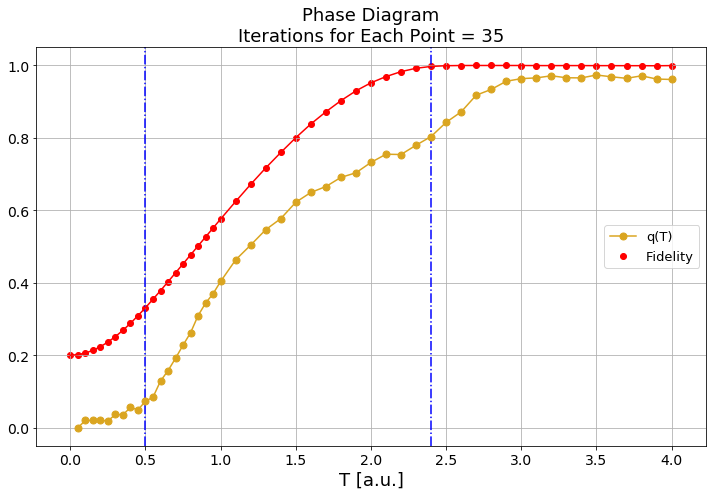

In [11]:
#PLOT 
#os.chdir("C:\Users\GUIDA\Desktop\CODE_MONTANGERO\SD_WITH_REPLACEMENT")
q=[]
for T in times[1:]:
    data = np.load(custom_name_dir +"/protocols/testT"+str(round(T, 2))+".npy")[0,:,:] #first dimension is redundant 
    #!warning: correlation normalization term musb be changed according to field values
    q.append(correlation(data,h))
    
loaded_fidelity = pd.read_csv(custom_name_dir +'/fidelity_SD.txt', skiprows=1,header=None)

q[0]=0
fig, ax = plt.subplots(figsize=(10,7))
#plot Fidelity values
ax.errorbar(times,loaded_fidelity.mean(axis=1).values, yerr=loaded_fidelity.std(axis=1).values, color="r")
ax.scatter(times,loaded_fidelity.mean(axis=1).values,color='r',label="Fidelity")
#plot Q values
ax.plot(times[1:], q, marker="o", color="goldenrod", markersize=7, label="q(T)")
ax.vlines(0.5,-0.05,1.05, color="b", linestyle="-.")
ax.vlines(2.4,-0.05,1.05, color="b", linestyle="-.")
ax.set_ylim(-0.05,1.05)
ax.set_title(r"Phase Diagram"+"\n"+"Iterations for Each Point = "+str(iter_for_each_time), fontsize=18)
ax.set_xlabel("T [a.u.]", fontsize=18)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.legend(fontsize=13, loc=5)
ax.grid()
fig.tight_layout()
fig.savefig("phase_diagram_final.pdf")
plt.show()